I have stepped into a role of an analyst for Zuber, a new ride-sharing company that's launching in Chicago. My task is to find patterns in the available information in order to understand passenger preferences and the impact of external factors on rides. We orginized the necessary data into a database, which include data on competitors' rides, cabs, trips, and data on weather coditions in the relevant period of time:
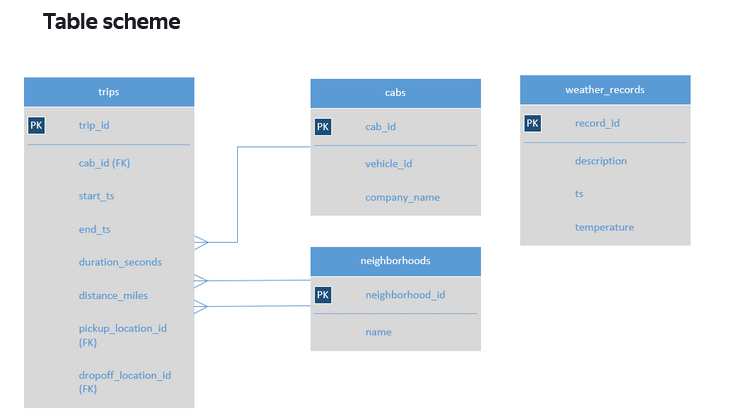


The ultimate goals is to test a hypothesis about the impact of weather on ride length.

## Content <a id='content'></a>

[Introduction](#intro)

[Dataset](#dataset)

[Data overview](#data_overview)

[Data preprocessing](#preprocessing)

[EDA - revealing patterns](#eda)

[SDA - Hypotheses testing](#sda)

[Summary and conclusions](#conclusions)

## Introduction <a id = "intro"> <a/>

The ultimate goal stated for the project is, based on the competitors' data, to determine the influence of weather conditions on the demand for taxi rides.

We will have to carefully study the data, evaluate its quality and see how significant its issues are and what are appropriate ways to fix them, if necessary. The next stage will be EDA: we will take a look at patterns the data can reveal to receive some qlues and enable further hypotheses testing. The next stage will be to formulate and test hypotheses with regard to the popularity of taxi rides under different weather conditions. At the end, we will make an overview of the findings. Thus, the project will consist of five stages:

 1. Data overview;
 2. Data preprocessing/transformation;
 3. Exploratory data analysis;
 4. Statistical data analysis;
 5. Summary and conclusions.

[Back to Content](#content)

## 1. Dataset <a id='dataset'> <a/>

### Weather data retrieval <a id = "weather_data"> <a/>

Our first task is to parse data from a weather site. Let's import the necessary libraries. If additional libraries are needed, we will add them here as well.

In [1]:
import requests
import re
from bs4 import BeautifulSoup
import json

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # We will need this for visualisations
%matplotlib inline
import seaborn as sns
from scipy import stats # We will need this in case we want to make some statistical checks
from scipy.stats import gaussian_kde

# To filter out automatic comments on plots from Jupyter (not affecting the output)
import warnings
warnings.filterwarnings("ignore") 

In [3]:
URL = 'https://code.s3.yandex.net/data-analyst-eng/chicago_weather_2017.html'
req_text = requests.get(URL).text
soup = BeautifulSoup(req_text, 'lxml')
table = soup.find('table',attrs={"id": "weather_records"})

In [4]:
heading_table = []  # List where the names of the columns will be stored
for row in table.find_all(
    'th'
):  # The names of the columns are inside <th> elements,
    # so we'll find all <th> elements in the table and run them through in a loop
    heading_table.append(
        "_".join(row.text.lower().split()) # transform the heading names into the standard form
    )  # Add the content from the <th> tag to the heading_table list using append()
print(heading_table) 

['date_and_time', 'temperature', 'description']


In [5]:
content = []  # list where the table data will be stored
for row in table.find_all('tr'):
    # Each row is wrapped in a <tr> tag, we need to loop through all the rows
    if not row.find_all('th'):
        # We need this condition to ignore the first row of the table, with headings
        content.append([element.text for element in row.find_all('td')])
        # Within each row the cell content is wrapped in <td> </td> tags
        # We need to loop through all <td> elements, extract the content from the cells, and add it to the list
        # Then add each of the lists to the content list
print(content[:3]) # print first 3 rows of the weather data

[['2017-11-01 00:00:00', '276.150', 'broken clouds'], ['2017-11-01 01:00:00', '275.700', 'scattered clouds'], ['2017-11-01 02:00:00', '275.610', 'overcast clouds']]


In [6]:
weather_records = pd.DataFrame(content, columns=heading_table) # call the resulting dataframe `weather_records`
# pass two-dimensional content list as data and heading_table as headings
weather_records.head() 

,date_and_time,temperature,description
0,2017-11-01 00:00:00,276.150,broken clouds
1,2017-11-01 01:00:00,275.700,scattered clouds
2,2017-11-01 02:00:00,275.610,overcast clouds
3,2017-11-01 03:00:00,275.350,broken clouds
4,2017-11-01 04:00:00,275.240,broken clouds


Thus, we have retrieved the necessary data and can extract some basic info about the dataset at hand.

In [7]:
# Define a dictionary for all the datasets to simplify sequential checks
dataset_dict = {'weather': weather_records}

In [8]:
# Define `raw_shape` function to print the shape of a dataframe
def raw_shape(df):
    raw_shape = df.shape
    print(f'length - {raw_shape[0]}; width - {raw_shape[1]}')

In [9]:
# Run a check for shapes, duplicates, and column names for each dataset
def dataset_ckeckups(dict):
    for key in dataset_dict:
        # header
        print('\n'+key+' dataframe shape:'+'\n'+'-'*(len(key) + 17))
        # df under consideration
        df = dataset_dict[key]
        # info
        raw_shape(df)
        print('duplicate number:', df.duplicated().sum(),'\n')
        print('missing values check:')
        print(df.isna().sum()/len(df),'\n')
        for col in list(df.columns):
            print(f"column name: '{col}'; column type: {df[col].dtype}")
    # no return


In [10]:
dataset_ckeckups(dataset_dict)


weather dataframe shape:
------------------------
length - 697; width - 3
duplicate number: 0 

missing values check:
date_and_time    0.0
temperature      0.0
description      0.0
dtype: float64 

column name: 'date_and_time'; column type: object
column name: 'temperature'; column type: object
column name: 'description'; column type: object


697 hourly data points (app. month of data) without missing values, data types should be fixed for further analysis.

### Data on competitors' rides <a id = "rides_data"> <a/>

At our disposal, we have a database with info on taxi rides in Chicago. Initially, it included three tables:

- **neighborhoods table**: data on city neighborhoods

    - name: name of the neighborhood
    - neighborhood_id: neighborhood code

- **cabs table**: data on taxis
    - cab_id: vehicle code
    - vehicle_id: the vehicle's technical ID
    - company_name: the company that owns the vehicle

- **trips table**: data on rides

    - trip_id: ride code
    - cab_id: code of the vehicle operating the ride
    - start_ts: date and time of the beginning of the ride (time rounded to the hour)
    - end_ts: date and time of the end of the ride (time rounded to the hour)
    - duration_seconds: ride duration in seconds
    - distance_miles: ride distance in miles
    - pickup_location_id: pickup neighborhood code
    - dropoff_location_id: dropoff neighborhood code

Let's run a couple of queries:

Find the number of taxi rides for each taxi company for November 15-16, 2017 (trips_amount), sort the results by the trips_amount field in descending order:

        SELECT company_name, count(trip_id) as trips_amount
        FROM trips JOIN cabs ON cabs.cab_id = trips.cab_id
        WHERE start_ts::date BETWEEN '2017-11-15' AND '2017-11-16'
        GROUP BY cabs.company_name ORDER BY count(trip_id) DESC

Find the number of rides for every taxi company whose name contains the words "Yellow" or "Blue" for November 1-7, 2017 (trips_amount):

        SELECT company_name, count(trip_id) as trips_amount
        FROM trips JOIN cabs ON cabs.cab_id = trips.cab_id
        WHERE (company_name LIKE '%Yellow%' OR company_name LIKE '%Blue%')
        AND (start_ts::date BETWEEN '2017-11-01' AND '2017-11-07')
        GROUP BY cabs.company_name ORDER BY count(trip_id) DESC

For November 1-7, 2017, find the number of rides for Flash Cab and Taxi Affiliation Services companies and join the rides for all other companies in the group "Other".

    SELECT company_name, sum(trips_amount) as trips_amount
        FROM
        (SELECT
        CASE
                WHEN company_name ='Flash Cab' THEN 'Flash Cab'
                WHEN company_name ='Taxi Affiliation Services' THEN 'Taxi Affiliation Services'
                ELSE 'Other'
            END as company_name, count(trip_id) as trips_amount

        FROM
            trips JOIN cabs ON cabs.cab_id = trips.cab_id
            WHERE (start_ts::date BETWEEN '2017-11-01' AND '2017-11-07')
            GROUP BY cabs.company_name) as subq
 
    GROUP BY company_name
    ORDER BY count(trips_amount) DESC

We have added the `weather_records` table to the database:
- **weather_records**: data on weather

    - record_id: weather record code
    - ts: record date and time (time rounded to the hour)
    - temperature: temperature when the record was taken
    - description: brief description of weather conditions, e.g. "light rain" or "scattered clouds"

Let's retrieve, for each hour, the weather condition records from the weather_records table. Using the CASE operator, we wll break all hours into two groups: Bad if the description field contains the words rain or storm, and Good for others.

    SELECT ts,
        CASE WHEN description LIKE '%rain%' OR description LIKE '%storm%' THEN 'Bad'
        ELSE 'Good' END as weather_conditions
    FROM weather_records

Now, we will retrive all the rides that started in the Loop (pickup_location_id: 50) on a Saturday and ended at O'Hare (dropoff_location_id: 63) and add the weather conditions for each ride. We will ignore rides for which data on weather conditions is not available.

    SELECT
        start_ts,

            CASE WHEN description LIKE '%rain%' OR description LIKE '%storm%' THEN 'Bad'
            ELSE 'Good' END as weather_conditions,

        duration_seconds

    FROM weather_records

    LEFT JOIN trips ON trips.start_ts = weather_records.ts

    WHERE pickup_location_id = 50 and dropoff_location_id = 63 
        AND EXTRACT(DOW from trips.start_ts) = 6

    ORDER BY
        trip_id

Following the SQL excercise, we have three CSVs at our disposal:
1. project_sql_result_01.csv, containing:

- company_name: taxi company name
- trips_amount: the number of rides for each taxi company on November 15-16, 2017.
2. project_sql_result_04.csv, containing:

- dropoff_location_name: Chicago neighborhoods where rides ended
- average_trips: the average number of rides that ended in each neighborhood in November 2017.
3. project_sql_result_07.csv, containing the result of the last SQL query which joined the data on rides with the weather conditions data; the data, in turn, were retrieved from a weather site parsing. The file contains data on rides from the Loop to O'Hare International Airport:

- pickup date and time
- weather conditions at the moment the ride started
- ride duration in seconds

Our further steps:

1. Import the files;
2. Study the data they contain;
3. Make sure the data types are correct;
4. Identify the top 10 neighborhoods in terms of drop-offs;
5. Visualize: taxi companies and number of rides, top 10 neighborhoods by number of dropoffs;
6. Draw conclusions based on each graph and explain the results.

#### Import data extracts from the SQL database <a id = "db_data"> <a/>

In [11]:
# function `load` for a csv load with try-except
def load(filename):
    try:
        df_raw = pd.read_csv(filename)
    except:
        df_raw = pd.read_csv('/'+filename)
    return df_raw

In [12]:
# Load the company file into a DataFrame
company_raw = load('datasets/project_sql_result_01.csv')
company_raw.head()

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


In [13]:
# Load the neighbourhood file into a DataFrame
nbh_raw = load('datasets/project_sql_result_04.csv')
nbh_raw.head()

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000


In [14]:
# Load the Saturdey rides from Loop to O'Hare with their weather conditions into a DataFrame
weather_raw = load('datasets/project_sql_result_07.csv')
weather_raw.head()

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


In [15]:
# Load the Saturdey rides from Loop to O'Hare with their weather conditions into a DataFrame
weather_raw = load('datasets/project_sql_result_07.csv')
weather_raw.head()

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


Let's run a couple of checks for these datasets, we will use the previously defined `dataset_ckeckups()` function:

In [16]:
dataset_dict = {'companies': company_raw, 'nbhs': nbh_raw, 'weather': weather_raw}

In [17]:
dataset_ckeckups(dataset_dict)


companies dataframe shape:
--------------------------
length - 64; width - 2
duplicate number: 0 

missing values check:
company_name    0.0
trips_amount    0.0
dtype: float64 

column name: 'company_name'; column type: object
column name: 'trips_amount'; column type: int64

nbhs dataframe shape:
---------------------
length - 94; width - 2
duplicate number: 0 

missing values check:
dropoff_location_name    0.0
average_trips            0.0
dtype: float64 

column name: 'dropoff_location_name'; column type: object
column name: 'average_trips'; column type: float64

weather dataframe shape:
------------------------
length - 1068; width - 3
duplicate number: 197 

missing values check:
start_ts              0.0
weather_conditions    0.0
duration_seconds      0.0
dtype: float64 

column name: 'start_ts'; column type: object
column name: 'weather_conditions'; column type: object
column name: 'duration_seconds'; column type: float64


In [18]:
nbh_raw['average_trips'].sum() # total average number of dropoffs for November 2017

56395.65044988819

In [19]:
nbh_raw['dropoff_location_name'].duplicated().sum() # checking that all the neighbourhood names are unique

0

In [20]:
company_raw['trips_amount'].sum() # total number of trips for the given days

137311

In [21]:
company_raw['company_name'].duplicated().sum() # checking that all the company names are unique

0

The data seems to be almost clean: no problems with column names or types, no missing values, though 197 duplicates in the `weather` dataframe; 64 companies and 94 neighbourhoods covered. For this part, only short preprocessing needed: checking what the meaning of the duplicates in the `weather` dataframe is and changing the `start_ts` variable's type. N.B. the total number of rides (averaged per day) for those two days seems to be higher that the monthly average.

## 2. Data Preprocessing <a id="preprocessing"> <a/>

### Duplicates in `weather` dataframe <a id = "weather_dup"> <a/>

Let's recap on how the `weather` dataframe looks like:

In [22]:
weather_raw.head(10)

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0
5,2017-11-11 04:00:00,Good,1320.0
6,2017-11-04 16:00:00,Bad,2969.0
7,2017-11-18 11:00:00,Good,2280.0
8,2017-11-11 14:00:00,Good,2460.0
9,2017-11-11 12:00:00,Good,2040.0


Let's plot the overall number of observations and those which are duplicates.

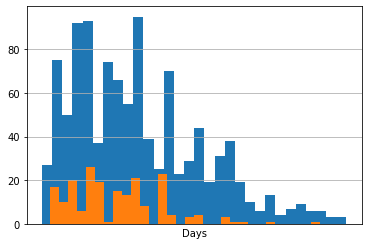

In [23]:
weather_raw['start_ts'].hist(bins = 30)
weather_raw[weather_raw.duplicated()]['start_ts'].hist(bins=30)
plt.xticks([])  # Disable xticks
plt.xlabel('Days')
plt.show()

Let's plot the overall number of observations for bad weather conditions and check whether the pattern for the duplicates resembles that for the full dataset.

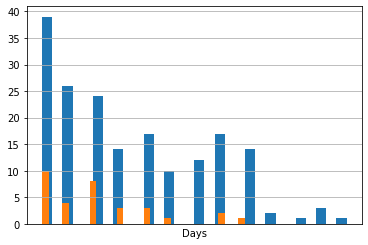

In [24]:
weather_bad = weather_raw[weather_raw['weather_conditions']=='Bad']
weather_bad['start_ts'].hist(bins = 30)
weather_bad[weather_bad.duplicated()]['start_ts'].hist(bins=30)
plt.xticks([])  # Disable xticks
plt.xlabel('Days')
plt.show()

First, there is nothing suspicios in the distribution of the duplicates. Second, we know that those duplicates are observations for the same route at the same timestamp; thus, given that the duration of the rides is measured in seconds, it is hard to believe that there would be almost 20% of the rides with exactly the same durations in seconds performed on the same rout at the same hour. Thus, it looks like it is better to drop the duplicates.

In [25]:
weather = weather_raw.drop_duplicates()

### `start_ts` type <a id = "weather_datetime_type"> <a/>

In [26]:
# Convert float to date when there are NaN values in the column
weather['start_ts']=pd.to_datetime(weather['start_ts'], format = '%Y-%m-%d %H:%M:%S')
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 871 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   start_ts            871 non-null    datetime64[ns]
 1   weather_conditions  871 non-null    object        
 2   duration_seconds    871 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 27.2+ KB


## 3. Exploratory data analysis <a id = "eda"> <a/>

Let's see what the top 10 neighborhoods in terms of drop-offs are and the top 10 companies in terms of rides.

In [27]:
nbh_raw.sort_values(by='average_trips', ascending = False).head(10) #they are already sorted actually

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
5,Lake View,2420.966667
6,Grant Park,2068.533333
7,Museum Campus,1510.000000
8,Gold Coast,1364.233333
9,Sheffield & DePaul,1259.766667


In [28]:
nbh_raw.sort_values(by='average_trips',
                    ascending = False).head(10)['average_trips'].sum()*10**4 / nbh_raw['average_trips'].sum()//100

76.0

Appr. 76% of all dropoffs fall on to the top 10 neighbourhoods.

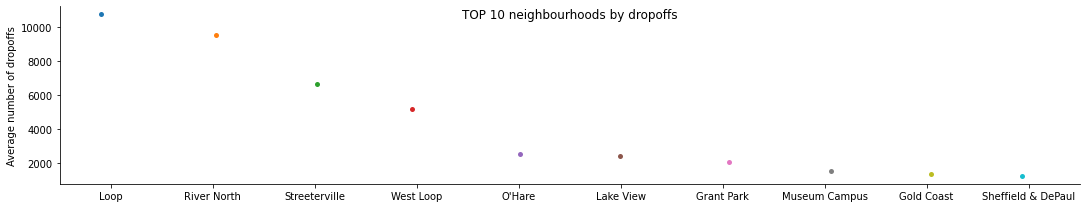

In [29]:
sns.catplot(y = 'average_trips', x = 'dropoff_location_name', 
            data = nbh_raw.head(10), height = 3, aspect = 5)
plt.title('TOP 10 neighbourhoods by dropoffs', y = 0.9)
plt.ylabel('Average number of dropoffs')
plt.xlabel('')
plt.show()

In [30]:
company_raw.sort_values(by='trips_amount', ascending = False).head(10) #they are already sorted actually

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
5,Chicago Carriage Cab Corp,9181
6,City Service,8448
7,Sun Taxi,7701
8,Star North Management LLC,7455
9,Blue Ribbon Taxi Association Inc.,5953


In [31]:
company_raw.sort_values(by='trips_amount',
                    ascending = False).head(10)['trips_amount'].sum()*10**4 / company_raw['trips_amount'].sum()//100

72.0

Appr. 72% of all rides were performed by the top 10 companies.

Let's visualize the average amount of trips by companies, but before that we will place all the companies which had less than 1000 trips into a separate group and call it `Others`.

In [32]:
company_raw['group'] = company_raw['company_name'].where(company_raw['trips_amount'] > 5500, 'Other')
companies = company_raw.pivot_table(index=['group'], values = 'trips_amount', aggfunc = 'sum')
companies = companies.sort_values(by='trips_amount', ascending = False).reset_index()

In [33]:
companies

,group,trips_amount
0,Other,38039
1,Flash Cab,19558
2,Taxi Affiliation Services,11422
3,Medallion Leasin,10367
4,Yellow Cab,9888
5,Taxi Affiliation Service Yellow,9299
6,Chicago Carriage Cab Corp,9181
7,City Service,8448
8,Sun Taxi,7701
9,Star North Management LLC,7455


Let's build a bar plot to visualize the last result.

In [34]:
#pip install --user matplotlib

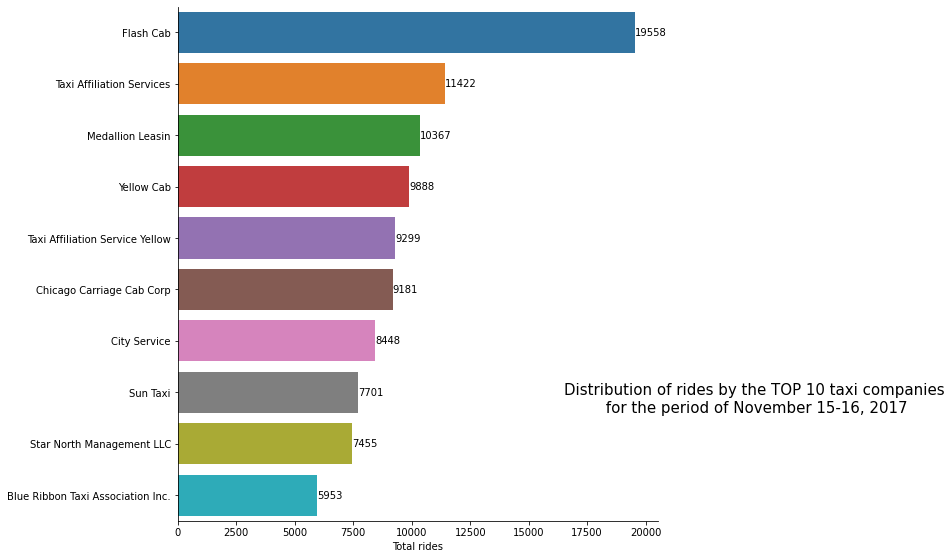

In [35]:
#sns.barplot( y = 'group', x = 'trips_amount', data = companies)
data = company_raw.query('trips_amount > 5500')
fig = sns.catplot( y = 'company_name', x = 'trips_amount', data = data, kind = 'bar')
fig.fig.set_size_inches(15,8)
plt.title('Distribution of rides by the TOP 10 taxi companies\n for the period of November 15-16, 2017',
        y =0.2, x = 1.2, fontsize = 15)
ax = fig.facet_axis(0,0)
for c in ax.containers:
    labels = [int(v.get_width()) for v in c]
    ax.bar_label(c, labels = labels)
plt.xlabel('Total rides')
plt.ylabel('')
plt.show()

#### EDA conclusions  <a id = "eda_conclusions"> <a/>

To sum up the findings from the numbers above:
    
1. At our disposal is data on appr. 137 thousands rides for the period of November 15-16, 2017 and 56 thosands dropoffs on average in that month.
2. Top ten destinations cover appr. 76% of dropoffs.
3. Top 10 taxi companies serve appr. 72% of the rides, with `Flash Cab` and `Taxi Affiliation Services` taking appr. 20% of all rides.
4. The `Loop` neighbourhood is leading in the amount of dropoffs, with `River North`, `Streeterville` and `West Loop` making up the absolute leaders with above 5000 dropoff (the next most popular destination, O'Hare airport makes appr. 2.5 thousands, looks like people prefer taking a taxi ride on their way back from the airport rather than the other way around).
    

Further steps: we will take data on rides from the Loop to O'Hare International Airport and test the hpothesis that  the duration of rides from the the Loop to O'Hare International Airport changes on rainy Saturdays.

[Back to Content](#content)

## 4. Testing the difference in ride duration for sunny and rainy days  <a id = 'sda'> <a/>


In what follows we employ numerical methods of hypothesis testing to conduct statistical significance checks for selected sample means. To this end, we employ the two-sample t-test to determine if two population means are equal, while populations are essentially the rides during the sunny hours and the rainy hours. The Python implementation of the t-test is [`scipy.stats.ttest_ind()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) function. Before applying it, we will check whether the two samples have equal variances. 

Let's take a look at two distributiuons:

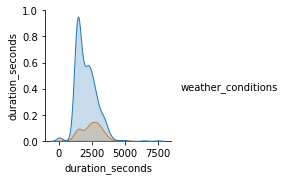

In [36]:
sns.pairplot(weather, diag_kind = 'kde', hue = 'weather_conditions', plot_kws = {'alpha': 0.5})
plt.show()

We cannot assume that durations are taken from normal distributions; thus, we will employ the Levene’s test has better performance in cases with significant deviations from normality; The Python implementation of this test is [`scipy.stats.levene()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html) function. 

#### Levene test

1. Null-hypothesis: `Bad` and `Good` hour ride samples have equal variance for `duration` distribution;
2. p-value: 5%;
3. The alternative hypothsis is that `Bad` and `Good` hour rides samples have different variance for `duration` distribution. If the p-value is smaller than 5%, then we will have evidence against the null hypothesis of equal variance, so that we will have to define the `equal_var` attribute of the t-test as `False` and perform [Welch's variation of the t-test](https://en.wikipedia.org/wiki/Welch%27s_t-test).

In [37]:
stat, p = stats.levene(weather[weather['weather_conditions']=='Bad']['duration_seconds'],
                      weather[weather['weather_conditions']=='Good']['duration_seconds'])
p

0.9806770360671218

The p-value is 98% and we cannopt reject the hypothesis of equal sample variables; thus, we can apply the standard t-test to the sample means:

#### t-test

In [38]:
# equal variances
stat, p = stats.ttest_ind(weather[weather['weather_conditions']=='Bad']['duration_seconds'],
                      weather[weather['weather_conditions']=='Good']['duration_seconds'], equal_var=True,)
p

7.397770692813604e-08

The p-value is essentially zero; thus we have to reject the hypothesis of equal means. Let's modify the t-test to test one-sided inequality, assuming that the ride duration during bad weather is higher than under good weather conditions:

1. Null-hypothesis: `Bad` and `Good` hour ride samples have equal means for `duration` distribution;
2. p-value: 5%;
3. The alternative hypothsis is that `Bad` hour rides sample have a greater `duration` mean than `Good` hour rides; if the p-value is smaller than 5%, we will have evidence against the null hypothesis of equal population means.

In [39]:
stat, p = stats.ttest_ind(weather[weather['weather_conditions']=='Bad']['duration_seconds'],
                          weather[weather['weather_conditions']=='Good']['duration_seconds'],
                          equal_var=True, alternative='greater')
p

3.698885346406802e-08

In this case as well, the null hypothesis is rejected; thus, we can accept that rides during bad weather conditions are, on average, longer than during good weather conditions.

[Back to Content](#content)

## General conclusion <a id="conclusions"> <a/>

We have loaded and investigated [3 datasets](#dataset): the number of rides for each taxi company on November 15-16, 2017;  the average number of rides by the neighbourhood they ended in, for in November 2017;  data on rides from the Loop to O'Hare International Airport with the weather conditions at the moment of their start. The datasets comprise results of specific queries to a database and there is no possibility to merge them directly.

During the check up of the data loaded, it turned out that two issues should be fixed: [duplicates in the weather data](#weather_dup) and the datetime [type of the `start_ts` variable](#weather_datetime_type).


The [exploratory analysis](#eda) showed that:
    
1. At our disposal is data on appr. 137 thousands rides for the period of November 15-16, 2017 and 56 thosands dropoffs on average in that month.
2. Top ten destinations cover appr. 76% of dropoffs; there is a long tail of 84 neighbourhoods making the rest of the dropoffs.
3. Top 10 taxi companies serve appr. 72% of the rides, with `Flash Cab` and `Taxi Affiliation Services` taking appr. 20% of all rides; there is a long tail of 54 companies making the rest of the rides.
4. The `Loop` neighbourhood is leading in the amount of dropoffs (unfortunately, the csv file does not contain the data on the pick-up locations to compare with), with `River North`, `Streeterville` and `West Loop` making up the absolute leaders with above 5000 dropoffs (the next most popular destination, O'Hare airport makes appr. 2.5 thousands).
    

[Statistical analysis](#sda) was possible for the third dataset, which contained data on ride duration and weather conditios for the ride. We have performed Levene test for non-normal distributions and showed that the sample distributions of the ride durations during bad and during good weather conditions have the same sample variance; then we performed two-sided and one-sided t-test for equal sample means and found that during the bad weather conditions the rides tend to take more time.